In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bapsflib import lapd
from bapsfda.processing import get_board_props, SISRun
from bapsfda.diagnostics import LangmuirSweep
from bapsfda.diagnostics._interferometer import Interferometer
from bapsfda.processing import sav_smooth, butt_low
from bapsfda.processing import sgaussian_half, expfit
from scipy.optimize import curve_fit
from astropy.constants import e, m_p
import astropy.units as u
import os

In [2]:
data_path = "./data/july2023/"
file_dict = {s[:2]: s for s in os.listdir(data_path)}
print(file_dict)

{'06': '06_xline_sweep_p20_3srep_125Vps_105Vpuff.hdf5', '07': '07_xline_sweep_p32_3srep_125Vps_105Vpuff.hdf5', '08': '08_xline_sweep_p43_3srep_125Vps_105Vpuff.hdf5', '09': '09_mach_cal_180_p20_3srep_125Vps_105Vpuff.hdf5', '10': '10_mach_cal_0_p20_3srep_125Vps_105Vpuff.hdf5', '11': '11_xline_mach_p20_3srep_125Vps_105Vpuff.hdf5', '12': '12_xline_mach_p20_3srep_125Vps_75Vpuff.hdf5', '13': '13_xline_sweep_p43_3srep_125Vps_75Vpuff.hdf5', '14': '14_xline_sweep_p32_3srep_125Vps_75Vpuff.hdf5', '15': '15_xline_sweep_p20_3srep_125Vps_75Vpuff.hdf5', '16': '16_xline_sweep_p20_3srep_125Vps_90Vpuff.hdf5', '17': '17_xline_sweep_p32_3srep_125Vps_90Vpuff.hdf5', '18': '18_xline_sweep_p43_3srep_125Vps_90Vpuff.hdf5', '19': '19_mach_cal_180_p20_3srep_125Vps_90Vpuff.hdf5', '20': '20_mach_cal_0_p20_3srep_125Vps_90Vpuff.hdf5', '21': '21_xline_mach_p20_3srep_125Vps_90Vpuff.hdf5', '22': '22_xline_Emissive_p38_3srep_125Vps_105Vpuff.hdf5', '23': '23_xline_Emissive_p38_3srep_125Vps_90Vpuff.hdf5', '24': '24_xline_E

In [3]:
with lapd.File(f"{data_path}{file_dict['15']}") as f:
    f.run_description()

Recording Langmuir sweeps and Isat on port 20, Unlucky #3 in x-line with 1cm point spacing x=[-30,30], 10 Shots per point. *3dB attenuator ADDED due to higher density*

LAPD B field:
Black magnets at south: 760 A (PS12, 13),
Yellow & Purple magnets: configured for uniform 1.5 kG
Black magnets at north: 0 A (PS11)

South LaB6 source:
He plasma , discharge PS voltage/current: 12V/7100A Control Room
90-76 V cathode-anode voltage, 1/3 Hz rep rate 
Heater: 2006A
Gas Puff (75 V on East and West, 28ms) Helium
Minimum background pressure on pfieffer box (2.1e-5, 2.7e-5)

Timing:
=====
Discharge Peried: 20 ms
Breakdown time: 6 ms
Sweep: Starting 0 ms, 96us ramp up, 28 cycles, 1ms pause
DAQ trigger: 0 ms  

Channels:
Board 1: 
Chan8: VAnode, G=1/40
Board 3:
Chan5: (UL3-LT) VSweep, G=1/100
Chan6: (UL3-LT) ISweep, G=1.02, R=1
Chan7: (UL3-LB) Isat, G=1.04, R=7.5
Chan8: (UL3-RT) VFloat, G=1/40


In [4]:
run15 = SISRun(f"{data_path}{file_dict['15']}")
run15.config_drive("fixed", run15.num_shots, 1, 1, 1)
run15.config_drive("xline", 10, nx = 61)
run15.rename_channel("b1_c8", "V_anode")
run15.rename_channel("b3_c5", "V_sweep")
run15.rename_channel("b3_c6", "I_sweep")
run15.rename_channel("b3_c7", "Isat")
run15.rename_channel("b3_c8", "V_float")
run15.set_drive_props("V_anode", "fixed")
run15.set_drive_props("V_sweep", "xline")
run15.set_drive_props("I_sweep", "xline")
run15.set_drive_props("Isat", "xline")
run15.set_drive_props("V_float", "xline")
run15.set_chan_props("V_anode", gain = 1/40)
run15.set_chan_props("V_sweep", gain = 1/100)
run15.set_chan_props("I_sweep", gain = 1.02/np.sqrt(2), resistance=1)
run15.set_chan_props("Isat", gain = 1.04, resistance = 7.5)
run15.set_chan_props("V_float", gain = 1/40)

{'clock rate': <Quantity 100. MHz>, 'shot average (software)': None, 'sample average (hardware)': 64, 'bit': 16, 'nshotnum': 610, 'nt': 75776}
{'clock rate': <Quantity 100. MHz>, 'shot average (software)': None, 'sample average (hardware)': 16, 'bit': 16, 'nshotnum': 610, 'nt': 249856}


In [5]:
run15.channel_dict

{'V_anode': SISCrateChannel(crate_index=(1, 8), board_props='board_1', channel_props=ChannelProperties(gain=0.025, resistance=None, units=Unit("V")), drive_props=DriveProperties(shots_per_pos=610, ny=1, nx=1, nz=1)),
 'V_sweep': SISCrateChannel(crate_index=(3, 5), board_props='board_3', channel_props=ChannelProperties(gain=0.01, resistance=None, units=Unit("V")), drive_props=DriveProperties(shots_per_pos=10, ny=1, nx=61, nz=1)),
 'I_sweep': SISCrateChannel(crate_index=(3, 6), board_props='board_3', channel_props=ChannelProperties(gain=0.7212489168102785, resistance=1, units=Unit("A")), drive_props=DriveProperties(shots_per_pos=10, ny=1, nx=61, nz=1)),
 'Isat': SISCrateChannel(crate_index=(3, 7), board_props='board_3', channel_props=ChannelProperties(gain=1.04, resistance=7.5, units=Unit("A")), drive_props=DriveProperties(shots_per_pos=10, ny=1, nx=61, nz=1)),
 'V_float': SISCrateChannel(crate_index=(3, 8), board_props='board_3', channel_props=ChannelProperties(gain=0.025, resistance=No

In [6]:
t_array = run15.board_props["board_3"].time_array
vsweep = run15.extract_signal("V_sweep")
isweep = run15.extract_signal("I_sweep")
vanode = run15.extract_signal("V_anode")
isat = run15.extract_signal("Isat")

In [7]:
isat = np.mean(isat.reshape(61,10,249856), axis = 1)
isat = np.moveaxis(np.moveaxis(isat, 0, 1) - np.mean(isat[:,-2000:-1],axis =-1), 0, 1)
freq = (1/isat.dt).to(u.Hz).value
isat = butt_low(isat, 10e3, freq)
ismooth = sav_smooth(isat, b = 60, axis=-1)

In [8]:
sweep_args = (0 * u.ms, 100 * u.us, 1 * u.ms, .96, 28)
sweeper = LangmuirSweep(*sweep_args)

In [9]:
v_slices, i_slices, ramp_times = sweeper.slice_sweeps(isweep, vsweep, t_array)

In [10]:
r_indices = [int(a) for a in ramp_times.to(u.s).value*freq]

In [11]:
isats = np.empty((61,28))
for i in range(61):
    for j in range(28):
        isats[i,j] = ismooth[i,r_indices[j]]

In [12]:
pp = sweeper.analyze_sweeps(v_slices, i_slices)

C:\Users\trloo\pythongits\BaPSF-Research\bapsfda\processing\_fitfuncs.py:40: RuntimeWarning: overflow encountered in exp
  return abs(amp) * np.exp(-abs(t - mean) / (np.sqrt(2) * std))


In [13]:
xpos = ((np.arange(61)-30)/100)*u.m
nish = (isats*u.A)*np.sqrt(4*m_p/(pp[:,:,1]*u.eV).to(u.J))/e.si*np.exp(1/2)
nlid = np.trapz(nish, xpos, axis=0)

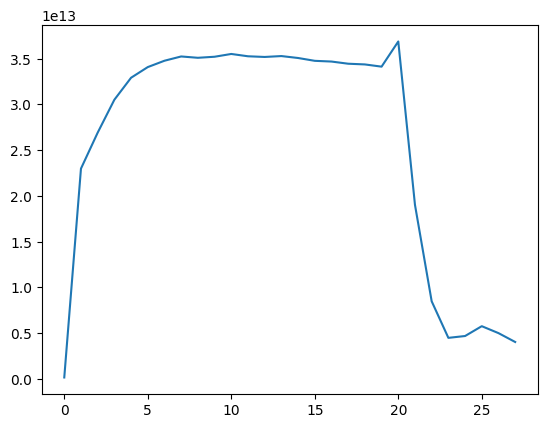

In [14]:
plt.plot(ramp_times, nlid)

In [15]:
with lapd.File(f"{data_path}{file_dict['15']}") as f:
    msi_int = f.read_msi("Interferometer array")

In [16]:
t_int, smint = run15.extract_interfero()

TypeError: File.read_msi() missing 1 required positional argument: 'msi_diag'

In [69]:
print(msi_int[0][2].__repr__())
print(msi_int[0][2][1])
print(msi_int[1][2].__repr__())
print(msi_int[1][2][1])

array([(3.77329653e+09, 1, 3.7085220e+09),
       (3.77329653e+09, 1, 6.4268696e+12)],
      dtype=[('timestamp', '<f8'), ('data valid', 'i1'), ('peak density', '<f4')])
(3.77329653e+09, 1, 6.4268696e+12)
array([(3.77329857e+09, 1, 6.5218836e+09),
       (3.77329857e+09, 1, 6.4641879e+12)],
      dtype=[('timestamp', '<f8'), ('data valid', 'i1'), ('peak density', '<f4')])
(3.77329857e+09, 1, 6.464188e+12)


In [170]:
interf = Interferometer(288e9, 2)
cal = interf._inter_params["cal_factor"]
avgint = (msi_int[1][1][1]+msi_int[0][1][1])*cal/2
smint = sav_smooth(avgint, b=40, axis=-1)

In [171]:
t_int = np.round(((np.arange(4096)-409.6)*2.442e-5)*1e3,2)

In [172]:
t_int_ramp_ind = np.arange(28)*41 + 410

In [173]:
fact = smint[t_int_ramp_ind]/nlid

In [174]:
a_probe_mm = ((1/fact)*u.m**2).to(u.mm**2)

In [187]:
np.std(a_probe_mm[5:18])

<Quantity 1.03042079 mm2>

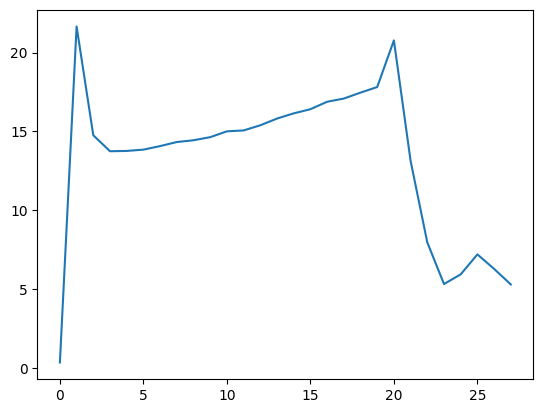

In [182]:
plt.plot(ramp_times, a_probe_mm)

In [177]:
c = np.mean(fact[3:20])

In [191]:
np.savez("run15.npz", probe_area = a_probe_mm, ramp_times = ramp_times, t_array = t_array, pp = pp, ism = ismooth)

In [189]:
area = (1/c*u.m**2).to(u.mm**2)

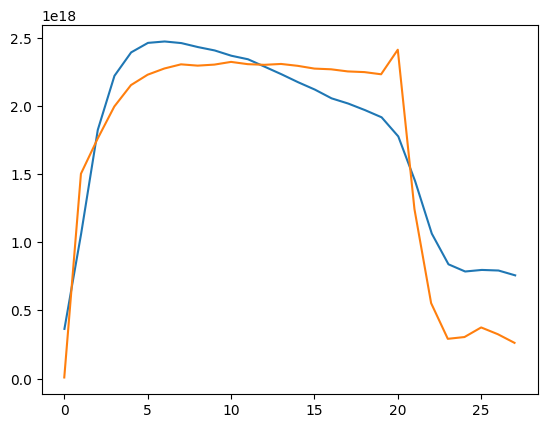

In [120]:
plt.plot(t_int[t_int_ramp_ind], smint[t_int_ramp_ind])
plt.plot(ramp_times, nlid*c)

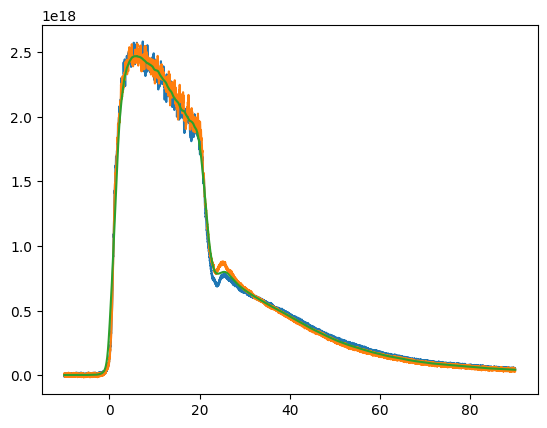

In [82]:
plt.plot(t_int, msi_int[1][1][1]*cal)
plt.plot(t_int, msi_int[0][1][1]*cal)
plt.plot(t_int, smint)